In [1]:
!pip install -U sentence-transformers

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [2]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, IterableDataset
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

In [3]:
os.chdir('..')
# os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
class RecommendationDatasetMultiLabel(IterableDataset):

    def __init__(self, dataset_filepath, article_emb_bag, total_articles):
        
        self.dataset_itr = open(dataset_filepath, 'r')
        next(self.dataset_itr)  # skip header
        
        self.article_emb_bag = article_emb_bag
        
        self.total_articles = total_articles
    
    def process_label(self, label_str: str):
        
        labels = torch.tensor([int(v) for v in label_str.split(',')])
        
        target = torch.zeros(self.total_articles).scatter_(0, labels, 1.)

        return target
    
    def mean_historical_purchases_embedding(self, input_str: str):
        
        indices = torch.tensor([int(v) for v in input_str.split(',')])

        mean_emb = self.article_emb_bag(indices.unsqueeze(0)).flatten()
            
        return mean_emb
    
    def process_numeric_features(self, fn: str, active: str, age: str):
        numeric_features_tensor = torch.tensor([
            float(fn),
            float(active),
            float(age)
        ])

        return numeric_features_tensor
    
    def parse_itr(self, dataset_itr):
        
        for line in dataset_itr:
        
            line_items = line.rstrip('\n').split('\t')
            
            customer_id_idx, article_id_idx_last10, article_id_idx_label, fn, active, age = line_items
            
            customer_id_idx = int(customer_id_idx)
            
            numeric_features_tensor = self.process_numeric_features(fn, active, age)
            
            mean_emb = self.mean_historical_purchases_embedding(article_id_idx_last10)

            label = self.process_label(article_id_idx_label)    
            
            inputs = torch.concat((mean_emb, numeric_features_tensor))

            yield customer_id_idx, inputs, label
        
    def get_stream(self, dataset_itr):
        
        return self.parse_itr(dataset_itr)

    def __iter__(self):
        
        return self.get_stream(self.dataset_itr)

In [11]:
articles_df = pd.read_csv('data/articles_df_filt_for_submission.csv', dtype={'article_id': str})
print(articles_df.shape)
articles_df.head()

(40538, 3)


,article_id,detail_desc,article_id_idx
0,0108775015,Jersey top with narrow shoulder straps.,0
1,0108775044,Jersey top with narrow shoulder straps.,1
2,0110065001,"Microfibre T-shirt bra with underwired, moulde...",2
3,0110065002,"Microfibre T-shirt bra with underwired, moulde...",3
4,0110065011,"Microfibre T-shirt bra with underwired, moulde...",4


In [9]:
customers = pd.read_csv('data/customers_filt_for_submission.csv')
print(customers.shape)
customers.head()

(47128, 5)


,customer_id,FN,Active,age,customer_id_idx
0,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,1.0,1.0,0.33,0
1,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.0,0.0,0.29,1
2,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.0,0.0,0.23,2
3,000fb6e772c5d0023892065e659963da90b1866035558e...,1.0,1.0,0.42,3
4,0010e8eb18f131e724d6997909af0808adbba057529edb...,1.0,1.0,0.25,4


### Create article EmbeddingBag

In [12]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [13]:
article_descriptions = articles_df['detail_desc'].to_list()
article_descriptions[:5]

['Jersey top with narrow shoulder straps.',
 'Jersey top with narrow shoulder straps.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.',
 'Microfibre T-shirt bra with underwired, moulded, lightly padded cups that shape the bust and provide good support. Narrow adjustable shoulder straps and a narrow hook-and-eye fastening at the back. Without visible seams for greater comfort.']

In [14]:
embeddings = model.encode(article_descriptions)

KeyboardInterrupt: 

In [ ]:
embeddings = torch.tensor(embeddings)

In [ ]:
embeddings.shape

In [ ]:
ARTICLE_EMBEDDING_BAG = nn.EmbeddingBag.from_pretrained(embeddings=embeddings, freeze=True)

### Model

In [16]:
class FashionRecV3(nn.Module):

    def __init__(self, user_embedding_dim):
        super(FashionRecV3, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customers), embedding_dim=user_embedding_dim)        
        
        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=user_embedding_dim+384+3, out_features=2048)            
        self.fc_2 = nn.Linear(in_features=2048, out_features=1024)
        # self.fc_3 = nn.Linear(in_features=1024, out_features=512)
        self.fc_3 = nn.Linear(in_features=1024, out_features=len(articles_df))
        
        # Activation functions
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(0.01)
        
    def forward(
        self, 
        customer_id_idx, 
        inputs
    ):

        user_emb = self.user_embeddings(customer_id_idx)
              
        concatenated_features = torch.concat(
            [
                user_emb, 
                inputs
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_features)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc_3(x)
        # x = self.relu(x)
        # x = self.dropout(x)
        
        # x = self.fc_4(x)

        return x

In [17]:
fashion_rec_v3 = FashionRecV3(user_embedding_dim=384)

In [18]:
fashion_rec_v3.to(device)

FashionRecV3(
  (user_embeddings): Embedding(43108, 384)
  (fc_1): Linear(in_features=771, out_features=2048, bias=True)
  (fc_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc_3): Linear(in_features=1024, out_features=40538, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.01, inplace=False)
)

In [19]:
BATCH_SIZE = 1024

In [20]:
total_training_examples = pd.read_csv('data/final_train_set_for_submission.tsv', sep='\t').shape[0]
total_batches = np.ceil(total_training_examples/BATCH_SIZE)
total_batches

43.0

In [22]:
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=fashion_rec_v3.parameters(), lr=0.001)  # 0.0001
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [23]:
MAX_EPOCHS = 75

training_losses = []

for epoch in range(MAX_EPOCHS):
    
    # Since we use an IterableDataset we need to reinstaniate the dataset since file end will have been reached:
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    for data in tqdm(train_loader, total=total_batches):
        
        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        loss = criterion(y_pred, label)

        loss.backward()    
        
        optimizer.step()
        
    # scheduler.step()
    
    # Compute train loss:
    
    total_train_loss = 0

    fashion_rec_v3.eval()
    
    train_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_train_set.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)  
    
    with torch.no_grad():
        for data in tqdm(train_loader, total=total_batches):

            customer_id_idx, inputs, label = data
            customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            y_pred = fashion_rec_v3(customer_id_idx, inputs)

            # loss = nn.BCEWithLogitsLoss(reduction='sum')(y_pred, label)
            loss = nn.CrossEntropyLoss(reduction='sum')(y_pred, label)

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / total_training_examples
        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)        
        
    fashion_rec_v3.train()

100%|██████████| 43/43.0 [00:10<00:00,  4.22it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.83it/s]


Training loss: 26.72099608468846


100%|██████████| 9/9.0 [00:02<00:00,  3.71it/s]


Dev loss: 126.30358544065241


100%|██████████| 43/43.0 [00:10<00:00,  4.28it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]


Training loss: 26.22265013345841


100%|██████████| 9/9.0 [00:02<00:00,  3.76it/s]


Dev loss: 123.94802652994791


100%|██████████| 43/43.0 [00:10<00:00,  4.29it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]


Training loss: 26.049741517217658


100%|██████████| 9/9.0 [00:02<00:00,  3.64it/s]


Dev loss: 123.13072996976082


100%|██████████| 43/43.0 [00:11<00:00,  3.89it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.72it/s]


Training loss: 25.863135194915603


100%|██████████| 9/9.0 [00:02<00:00,  3.72it/s]


Dev loss: 122.24868771737081


100%|██████████| 43/43.0 [00:09<00:00,  4.44it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]


Training loss: 25.572146358102398


100%|██████████| 9/9.0 [00:02<00:00,  3.79it/s]


Dev loss: 120.87325495669717


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.82it/s]


Training loss: 25.48648209760768


100%|██████████| 9/9.0 [00:02<00:00,  3.80it/s]


Dev loss: 120.46834103768332


100%|██████████| 43/43.0 [00:09<00:00,  4.42it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]


Training loss: 24.971684206944623


100%|██████████| 9/9.0 [00:02<00:00,  3.81it/s]


Dev loss: 118.03501785010623


100%|██████████| 43/43.0 [00:09<00:00,  4.36it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.93it/s]


Training loss: 24.988706451583088


100%|██████████| 9/9.0 [00:02<00:00,  3.83it/s]


Dev loss: 118.11547781961006


100%|██████████| 43/43.0 [00:09<00:00,  4.38it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.91it/s]


Training loss: 24.132838336724767


100%|██████████| 9/9.0 [00:02<00:00,  3.81it/s]


Dev loss: 114.06999945389597


100%|██████████| 43/43.0 [00:09<00:00,  4.34it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 23.62734632800901


100%|██████████| 9/9.0 [00:02<00:00,  3.61it/s]


Dev loss: 111.68066288462856


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]


Training loss: 23.580907930146015


100%|██████████| 9/9.0 [00:02<00:00,  3.81it/s]


Dev loss: 111.46115998385245


100%|██████████| 43/43.0 [00:09<00:00,  4.45it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.88it/s]


Training loss: 22.414291026453544


100%|██████████| 9/9.0 [00:02<00:00,  3.79it/s]


Dev loss: 105.94684841758327


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]


Training loss: 21.958582489900003


100%|██████████| 9/9.0 [00:02<00:00,  3.84it/s]


Dev loss: 103.79282609370716


100%|██████████| 43/43.0 [00:09<00:00,  4.45it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.86it/s]


Training loss: 22.069021082858026


100%|██████████| 9/9.0 [00:02<00:00,  3.78it/s]


Dev loss: 104.31484219735128


100%|██████████| 43/43.0 [00:09<00:00,  4.36it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.94it/s]


Training loss: 21.366800875104932


100%|██████████| 9/9.0 [00:02<00:00,  3.83it/s]


Dev loss: 100.99561975044116


100%|██████████| 43/43.0 [00:09<00:00,  4.33it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]


Training loss: 20.65709970656005


100%|██████████| 9/9.0 [00:02<00:00,  3.87it/s]


Dev loss: 97.64103663929721


100%|██████████| 43/43.0 [00:09<00:00,  4.42it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 20.43143920388726


100%|██████████| 9/9.0 [00:02<00:00,  3.67it/s]


Dev loss: 96.57439486854955


100%|██████████| 43/43.0 [00:09<00:00,  4.50it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 19.44981875441297


100%|██████████| 9/9.0 [00:02<00:00,  3.88it/s]


Dev loss: 91.93451610364411


100%|██████████| 43/43.0 [00:09<00:00,  4.50it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.93it/s]


Training loss: 18.764830537703812


100%|██████████| 9/9.0 [00:02<00:00,  3.89it/s]


Dev loss: 88.69674504597982


100%|██████████| 43/43.0 [00:09<00:00,  4.45it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.90it/s]


Training loss: 17.268991768199747


100%|██████████| 9/9.0 [00:02<00:00,  3.83it/s]


Dev loss: 81.62628258153012


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]


Training loss: 17.275520234799533


100%|██████████| 9/9.0 [00:02<00:00,  3.88it/s]


Dev loss: 81.65714103966428


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.04it/s]


Training loss: 16.42044061436175


100%|██████████| 9/9.0 [00:02<00:00,  3.90it/s]


Dev loss: 77.61538969341078


100%|██████████| 43/43.0 [00:09<00:00,  4.40it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 15.592456626131062


100%|██████████| 9/9.0 [00:02<00:00,  3.87it/s]


Dev loss: 73.70171274553266


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.98it/s]


Training loss: 15.787526409867368


100%|██████████| 9/9.0 [00:02<00:00,  3.61it/s]


Dev loss: 74.62375970137747


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 15.981281580327227


100%|██████████| 9/9.0 [00:02<00:00,  3.86it/s]


Dev loss: 75.53959280315199


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 16.248341290198816


100%|██████████| 9/9.0 [00:02<00:00,  3.86it/s]


Dev loss: 76.80191845810204


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 14.29536711392027


100%|██████████| 9/9.0 [00:02<00:00,  3.85it/s]


Dev loss: 67.57068920470121


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]


Training loss: 13.452728832167354


100%|██████████| 9/9.0 [00:02<00:00,  3.85it/s]


Dev loss: 63.58774501064367


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 13.013912795945467


100%|██████████| 9/9.0 [00:02<00:00,  3.85it/s]


Dev loss: 61.51356938680013


100%|██████████| 43/43.0 [00:09<00:00,  4.45it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]


Training loss: 13.584739144905672


100%|██████████| 9/9.0 [00:02<00:00,  3.68it/s]


Dev loss: 64.21172533537212


100%|██████████| 43/43.0 [00:09<00:00,  4.51it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]


Training loss: 13.63604449190478


100%|██████████| 9/9.0 [00:02<00:00,  3.88it/s]


Dev loss: 64.4542331093236


100%|██████████| 43/43.0 [00:09<00:00,  4.52it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 12.987494863804102


100%|██████████| 9/9.0 [00:02<00:00,  3.88it/s]


Dev loss: 61.388698310182804


100%|██████████| 43/43.0 [00:09<00:00,  4.48it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.91it/s]


Training loss: 11.954023457661933


100%|██████████| 9/9.0 [00:02<00:00,  3.83it/s]


Dev loss: 56.50373280843099


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]


Training loss: 12.149503140300416


100%|██████████| 9/9.0 [00:02<00:00,  3.86it/s]


Dev loss: 57.42771725570947


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.98it/s]


Training loss: 11.033887905812147


100%|██████████| 9/9.0 [00:02<00:00,  3.73it/s]


Dev loss: 52.154478053042766


100%|██████████| 43/43.0 [00:09<00:00,  4.39it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]


Training loss: 10.27468369296257


100%|██████████| 9/9.0 [00:02<00:00,  3.89it/s]


Dev loss: 48.56590621011299


100%|██████████| 43/43.0 [00:09<00:00,  4.42it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.91it/s]


Training loss: 9.981622678047541


100%|██████████| 9/9.0 [00:02<00:00,  3.83it/s]


Dev loss: 47.18067877250805


100%|██████████| 43/43.0 [00:10<00:00,  4.27it/s]
100%|██████████| 43/43.0 [00:13<00:00,  3.20it/s]


Training loss: 9.686712662342076


100%|██████████| 9/9.0 [00:02<00:00,  3.89it/s]


Dev loss: 45.78671156230726


100%|██████████| 43/43.0 [00:09<00:00,  4.49it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.87it/s]


Training loss: 9.182422874035128


100%|██████████| 9/9.0 [00:02<00:00,  3.78it/s]


Dev loss: 43.40305759363007


100%|██████████| 43/43.0 [00:09<00:00,  4.48it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.91it/s]


Training loss: 8.72125776223109


100%|██████████| 9/9.0 [00:02<00:00,  3.89it/s]


Dev loss: 41.22324337875634


100%|██████████| 43/43.0 [00:09<00:00,  4.38it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.93it/s]


Training loss: 8.32561444992854


100%|██████████| 9/9.0 [00:02<00:00,  3.79it/s]


Dev loss: 39.35313461705258


100%|██████████| 43/43.0 [00:09<00:00,  4.40it/s]
100%|██████████| 43/43.0 [00:11<00:00,  3.80it/s]


Training loss: 8.006858509237519


100%|██████████| 9/9.0 [00:02<00:00,  3.87it/s]


Dev loss: 37.84645357633892


100%|██████████| 43/43.0 [00:09<00:00,  4.43it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.02it/s]


Training loss: 7.6613980297079065


100%|██████████| 9/9.0 [00:02<00:00,  3.67it/s]


Dev loss: 36.21354673954478


100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.95it/s]


Training loss: 7.478758664081167


100%|██████████| 9/9.0 [00:02<00:00,  3.85it/s]


Dev loss: 35.35025531701874


100%|██████████| 43/43.0 [00:09<00:00,  4.60it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]


Training loss: 7.2275323583739715


100%|██████████| 9/9.0 [00:02<00:00,  3.91it/s]


Dev loss: 34.16277027464749


100%|██████████| 43/43.0 [00:09<00:00,  4.63it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.09it/s]


Training loss: 7.149115300592226


100%|██████████| 9/9.0 [00:02<00:00,  4.00it/s]


Dev loss: 33.79211210284317


100%|██████████| 43/43.0 [00:09<00:00,  4.59it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.04it/s]


Training loss: 6.940977075496609


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 32.808293834485504


100%|██████████| 43/43.0 [00:09<00:00,  4.48it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.03it/s]


Training loss: 6.880226069416132


100%|██████████| 9/9.0 [00:02<00:00,  3.91it/s]


Dev loss: 32.52113875004283


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]


Training loss: 6.8708100982153475


100%|██████████| 9/9.0 [00:02<00:00,  3.86it/s]


Dev loss: 32.4766317668714


100%|██████████| 43/43.0 [00:09<00:00,  4.62it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.05it/s]


Training loss: 6.659283419514649


100%|██████████| 9/9.0 [00:02<00:00,  3.99it/s]


Dev loss: 31.47679711057429


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.00it/s]


Training loss: 6.534826834590954


100%|██████████| 9/9.0 [00:02<00:00,  3.85it/s]


Dev loss: 30.888521401924


100%|██████████| 43/43.0 [00:09<00:00,  4.48it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.05it/s]


Training loss: 6.464543712396861


100%|██████████| 9/9.0 [00:02<00:00,  3.96it/s]


Dev loss: 30.55631034583376


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.07it/s]


Training loss: 6.258464693237769


100%|██████████| 9/9.0 [00:02<00:00,  3.96it/s]


Dev loss: 29.582225438168173


100%|██████████| 43/43.0 [00:09<00:00,  4.50it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.08it/s]


Training loss: 6.2470628197365485


100%|██████████| 9/9.0 [00:02<00:00,  3.93it/s]


Dev loss: 29.528331582588063


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.04it/s]


Training loss: 6.209877432548591


100%|██████████| 9/9.0 [00:02<00:00,  3.73it/s]


Dev loss: 29.352565390603583


100%|██████████| 43/43.0 [00:09<00:00,  4.52it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.02it/s]


Training loss: 6.062914877087417


100%|██████████| 9/9.0 [00:02<00:00,  3.91it/s]


Dev loss: 28.657909487004865


100%|██████████| 43/43.0 [00:09<00:00,  4.54it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]


Training loss: 5.904216395754467


100%|██████████| 9/9.0 [00:02<00:00,  3.97it/s]


Dev loss: 27.907780744318377


100%|██████████| 43/43.0 [00:09<00:00,  4.67it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 5.867872650353201


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 27.735992786340546


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.06it/s]


Training loss: 5.805157978149539


100%|██████████| 9/9.0 [00:02<00:00,  3.94it/s]


Dev loss: 27.439555934437536


100%|██████████| 43/43.0 [00:09<00:00,  4.50it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.07it/s]


Training loss: 5.81454921416939


100%|██████████| 9/9.0 [00:02<00:00,  3.94it/s]


Dev loss: 27.483946000483996


100%|██████████| 43/43.0 [00:09<00:00,  4.51it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.06it/s]


Training loss: 5.73120263871229


100%|██████████| 9/9.0 [00:02<00:00,  3.95it/s]


Dev loss: 27.089987209386994


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.96it/s]


Training loss: 5.668409511951632


100%|██████████| 9/9.0 [00:02<00:00,  3.96it/s]


Dev loss: 26.7931795220626


100%|██████████| 43/43.0 [00:09<00:00,  4.57it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.99it/s]


Training loss: 5.662317028755357


100%|██████████| 9/9.0 [00:02<00:00,  3.88it/s]


Dev loss: 26.764381850393196


100%|██████████| 43/43.0 [00:09<00:00,  4.52it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.97it/s]


Training loss: 5.587101922447146


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 26.40885851676004


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  3.92it/s]


Training loss: 5.5778753290019765


100%|██████████| 9/9.0 [00:02<00:00,  3.77it/s]


Dev loss: 26.36524667572557


100%|██████████| 43/43.0 [00:09<00:00,  4.41it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.06it/s]


Training loss: 5.5839713023082105


100%|██████████| 9/9.0 [00:02<00:00,  3.91it/s]


Dev loss: 26.394060844287537


100%|██████████| 43/43.0 [00:09<00:00,  4.53it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.07it/s]


Training loss: 5.559213808740547


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 26.277038252981086


100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.01it/s]


Training loss: 5.5127709282454465


100%|██████████| 9/9.0 [00:02<00:00,  3.66it/s]


Dev loss: 26.057514163904024


100%|██████████| 43/43.0 [00:09<00:00,  4.61it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.03it/s]


Training loss: 5.448522356254023


100%|██████████| 9/9.0 [00:02<00:00,  3.80it/s]


Dev loss: 25.753826944451582


100%|██████████| 43/43.0 [00:09<00:00,  4.59it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.07it/s]


Training loss: 5.503197521228477


100%|██████████| 9/9.0 [00:02<00:00,  3.90it/s]


Dev loss: 26.012263020297937


100%|██████████| 43/43.0 [00:09<00:00,  4.57it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.03it/s]


Training loss: 5.39738475540811


100%|██████████| 9/9.0 [00:02<00:00,  3.70it/s]


Dev loss: 25.51211206536544


100%|██████████| 43/43.0 [00:09<00:00,  4.60it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.06it/s]


Training loss: 5.412057477843621


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 25.581466420491537


100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.01it/s]


Training loss: 5.402204023837114


100%|██████████| 9/9.0 [00:02<00:00,  3.92it/s]


Dev loss: 25.534891563549376


100%|██████████| 43/43.0 [00:09<00:00,  4.58it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.01it/s]


Training loss: 5.350366775584905


100%|██████████| 9/9.0 [00:02<00:00,  3.97it/s]


Dev loss: 25.289869623016894


100%|██████████| 43/43.0 [00:09<00:00,  4.55it/s]
100%|██████████| 43/43.0 [00:10<00:00,  4.03it/s]


Training loss: 5.351039827362199


100%|██████████| 9/9.0 [00:02<00:00,  3.89it/s]

Dev loss: 25.293050973457202


In [24]:
training_losses[-1], dev_losses[-1]

(5.351039827362199, 25.293050973457202)

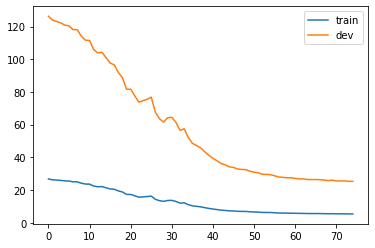

In [25]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Submission

In [15]:
total_sub_batches = np.ceil(pd.read_csv('data/final_submission_inputs_for_submission.tsv', sep='\t').shape[0]/BATCH_SIZE)
total_sub_batches

NameError: name 'BATCH_SIZE' is not defined

In [45]:
fashion_rec_v3.eval()

predictions = []

dev_dataset = RecommendationDatasetMultiLabel(dataset_filepath='data/final_submission_inputs_for_submission.tsv', article_emb_bag=ARTICLE_EMBEDDING_BAG, total_articles=len(articles_df))    

dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE)  

with torch.no_grad():
    for data in tqdm(dev_loader, total=total_sub_batches):

        customer_id_idx, inputs, label = data
        customer_id_idx, inputs, label = customer_id_idx.to(device), inputs.to(device), label.to(device)

        y_pred = fashion_rec_v3(customer_id_idx, inputs)
        
        predictions.append(y_pred.topk(12, dim=1).indices)

100%|██████████| 43/43.0 [00:09<00:00,  4.56it/s]


In [46]:
predictions = torch.concat(predictions)

In [47]:
predictions.shape

torch.Size([43108, 12])

In [48]:
sample_submission = pd.read_csv('data/sample_submission.csv')
print(sample_submission.shape)
sample_submission.head()

(1371980, 2)


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...


In [49]:
article_idx_to_id = dict(zip(articles_df['article_id_idx'], articles_df['article_id']))

In [50]:
predictions_article_id = [[article_idx_to_id[i] for i in l] for l in predictions.tolist()]
predictions_article_id[0]

['0685814001',
 '0685814005',
 '0685814003',
 '0685814033',
 '0685814065',
 '0685814022',
 '0794575017',
 '0685814063',
 '0919499007',
 '0794575001',
 '0456163083',
 '0850917001']

In [51]:
predictions_strings = [' '.join(l) for l in predictions_article_id]
predictions_strings[0]

'0685814001 0685814005 0685814003 0685814033 0685814065 0685814022 0794575017 0685814063 0919499007 0794575001 0456163083 0850917001'

In [52]:
submission_set_filt = pd.read_csv('data/final_submission_inputs_for_submission.tsv', sep='\t')
print(submission_set_filt.shape)
submission_set_filt.head()

(43108, 6)


,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21


In [53]:
len(predictions_strings)

43108

In [54]:
customer_idx_to_id = dict(zip(customers['customer_id_idx'], customers['customer_id']))

In [55]:
submission_set_filt['customer_id'] = submission_set_filt['customer_id_idx'].map(customer_idx_to_id)

In [56]:
submission_set_filt['prediction_model'] = predictions_strings

In [57]:
submission_set_filt.isnull().sum()

customer_id_idx          0
article_id_idx_last10    0
article_id_idx_label     0
FN                       0
Active                   0
age                      0
customer_id              0
prediction_model         0
dtype: int64

In [58]:
submission_set_filt.head()

,customer_id_idx,article_id_idx_last10,article_id_idx_label,FN,Active,age,customer_id,prediction_model
0,0,"15861,7705,7705,7705",0,0.0,0.0,0.45,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0685814001 0685814005 0685814003 0685814033 06...
1,1,"17255,26222,39644,31316,3160,38515,39642,40340...",0,1.0,1.0,0.44,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0935858001 0909869004 0888024005 0923134003 05...
2,2,"21627,21175,23351,23816",0,0.0,0.0,0.21,0001f8cef6b9702d54abf66fd89eb21014bf98567065a9...,0820671001 0910933001 0399223001 0760084015 07...
3,3,"36213,38872,37897,38110,5642,4783,34346,34346,...",0,1.0,1.0,0.33,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0904026001 0905914002 0913367001 0574109039 07...
4,4,"21522,31083,23930,15224,21141,37733,10396,3782...",0,0.0,0.0,0.21,0005340aa69bb5a28d98712a36d8f669024bce137e3c82...,0759814022 0937066001 0806388019 0759814036 08...


In [59]:
sample_submission = sample_submission.merge(submission_set_filt[['customer_id', 'prediction_model']], on='customer_id', how='left')
sample_submission.head()

,customer_id,prediction,prediction_model
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,NaN
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,NaN


In [60]:
sample_submission.isnull().sum()

customer_id               0
prediction                0
prediction_model    1328872
dtype: int64

In [61]:
sample_submission['prediction_model'].fillna(
    '0751471001 0706016001 0372860002 0610776002 0448509014 0730683050 0918292001 0760084003 0866731001 0372860001 0827968001 0706016003',
    inplace=True
)

In [62]:
sample_submission.drop(columns=['prediction'], inplace=True)
sample_submission.rename(columns={'prediction_model': 'prediction'}, inplace=True)

In [63]:
sample_submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0751471001 0706016001 0372860002 0610776002 04...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0751471001 0706016001 0372860002 0610776002 04...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0751471001 0706016001 0372860002 0610776002 04...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0751471001 0706016001 0372860002 0610776002 04...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0751471001 0706016001 0372860002 0610776002 04...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0809961007 0720125039 0791587015 0896559001 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0751471001 0706016001 0372860002 0610776002 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0751471001 0706016001 0372860002 0610776002 04...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0751471001 0706016001 0372860002 0610776002 04...


In [64]:
sample_submission.to_csv('data/20220503-fashionrecv3_2.csv', index=False)